---
## **Chicago 311 - Exploratory Data Analysis**
---


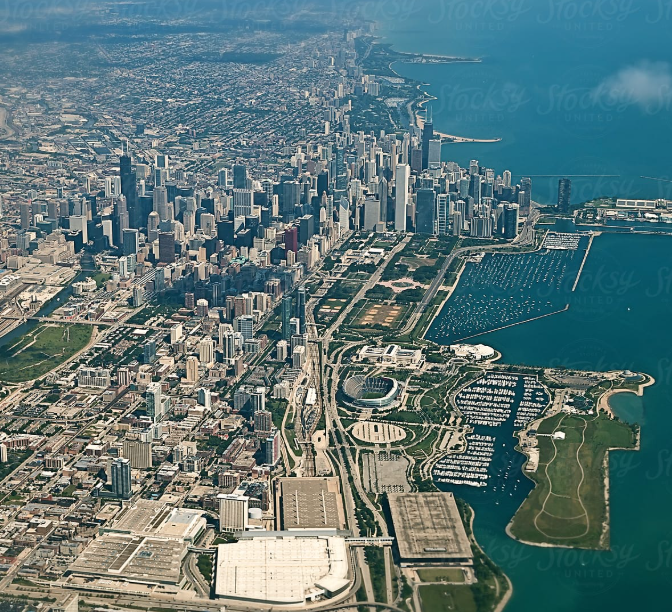

---


### **What 13.3M service requests can tell us about how a city really works?**
---


This notebook uses **Exploratory Data Analysis** to find patterns hidden in **over 6 years of [Chicago 311 Official Data](https://data.cityofchicago.org/Service-Requests/311-Service-Requests/v6vf-nfxy/about_data)** to understand:

**🏙️ Urban Rhythms**
- When and where does the city need help most? ⚠️
- What drives seasonal spikes and geographic hotspots? ❌

**🔍 System Behavior**  
- Which requests get resolved quickly vs. stuck in limbo? ❌
- Are there invisible bottlenecks in city operations? ❌

**🎯 Data Storytelling**
- What do these patterns reveal about inequality, infrastructure, and citizen engagement? ⚠️

**🧭 Role in the Project**
- A foundational study for guiding further analysis and modeling (e.g. segmentation, forecasting, anomaly detection, optimization). 
---

---
## **🏙️Domain Analysis**
---

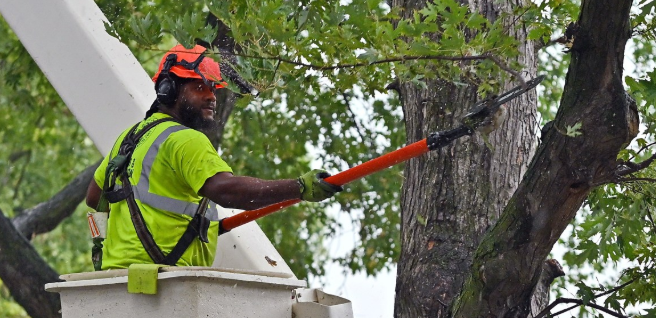

The **[Chicago 311 - Service Requests](https://311.chicago.gov/s/?language=en_US)** is Chicago’s official system for **non-emergency service requests**.

---

---
### The **city's customer service desk**.
---



**How it works:**
1. **Citizens submit requests through official channels** → Phone, web, app, walk-in, email
2. **Requests are routed to respective Departments** → Streets, Sanitation, Aviation, etc.
3. **Departments handles requests** → Fix pothole, remove graffiti, trim tree
4. **Status updates tracked** → Open → In Progress → Completed

**Why this data matters:**
- **13.3M records over 6 years** = comprehensive urban snapshot
- **Spatially tagged** = every request has a location
- **Time-stamped** = shows when demand peaks
- **Daily updated** = living dataset for real-world ML

This detailed database provides a **real-time window** into **urban inequality**, **infrastructure decay**, and **citizen behavior**.

Enables **exceptional inteligence source** for use in **strategic planning and operational action** for **public services.**

---

**Service Requests Formulary**

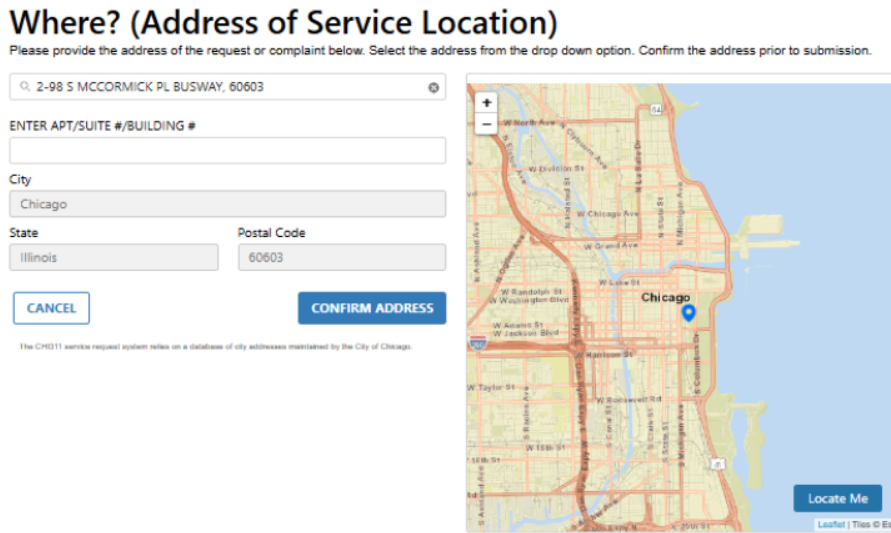

---

##### **Service Requests examples**
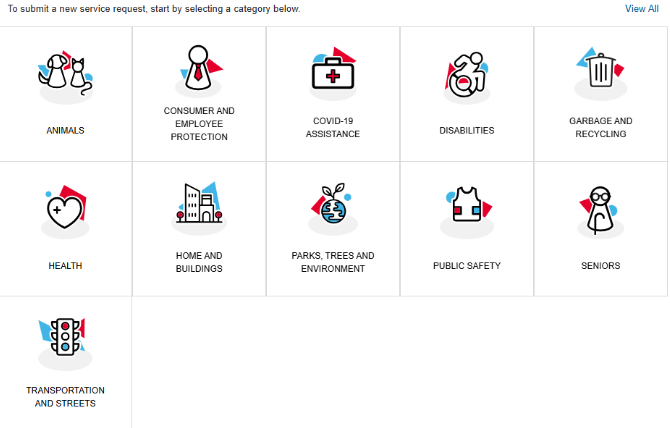

---

---
## **🔍 Data Understanding 1 - Dataset Context**
---


### **Data Value**


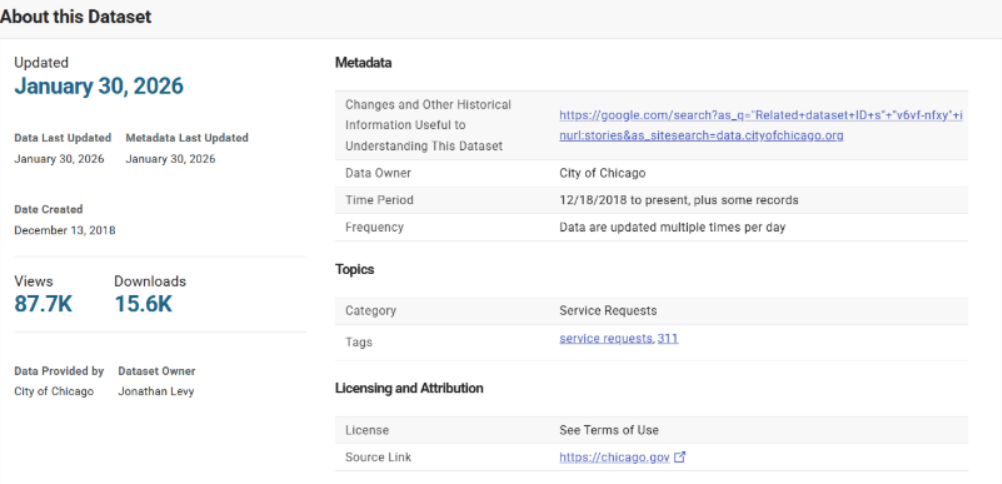
- High-volume, high-quality, spatial and time-stamped records
- Reflects real urban demand
- **[Daily Updated](https://data.cityofchicago.org/Service-Requests/311-Service-Requests/v6vf-nfxy/about_data)** -> will be used in a future **[ML Engineering Project]()**

---

### **Dataset characteristics**

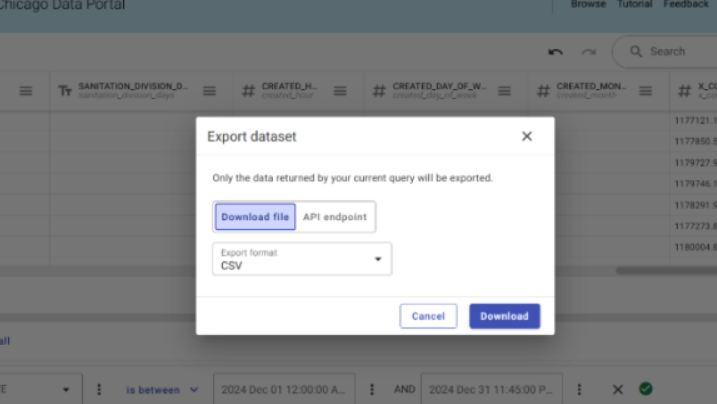

- Data is available via file downloads and an API; **direct CSV downloads** were used for reproducibility.
- **Over six years of data** were merged and converted into a **single Parquet file (~13.3M records)**.
- Due to dataset size, **pandas-based EDA can be slow or unstable**.
- **DuckDB with SQL and sampling** is used to enable fast, interactive exploration while preserving representativeness.
- Data ingestion and engineering steps are **out of scope** for this notebook.

---


---
## **🔍 Data Understanding 2 - Hands on Dataset analysis**
---

---
### **Preparation**
---

#### **Setting up**

In [32]:
# Importing Python libraries
import numpy as np
from pathlib import Path
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geoviews as gv
import cartopy.crs as ccrs
from holoviews.operation.datashader import datashade
from colorcet import fire

In [33]:
# Initialize DuckDB database
con = duckdb.connect()

#### **Loading the Data**


In [34]:
# Preview
df_sample = con.execute("""
    SELECT *
    FROM 'data/processed/data.parquet'
    USING SAMPLE .1%
""").df()

df_sample

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,CITY,CLOSED_DATE,COMMUNITY_AREA,CREATED_DATE,CREATED_DAY_OF_WEEK,CREATED_DEPARTMENT,CREATED_HOUR,CREATED_MONTH,DUPLICATE,ELECTRICAL_DISTRICT,...,STATUS,STREET_ADDRESS,STREET_DIRECTION,STREET_NAME,STREET_NUMBER,STREET_TYPE,WARD,X_COORDINATE,Y_COORDINATE,ZIP_CODE
0,None,2019-12-31 06:52:50,57,2019-12-27 11:32:36,6,None,11,12,False,None,...,Completed,4713 S KILDARE AVE,S,KILDARE,4713,AVE,14,"1148560,458131","1872958,414488",60632
1,None,2019-12-27 11:34:47,22,2019-12-27 11:32:49,6,Streets and Sanitation,11,12,False,None,...,Completed,3322 W PALMER ST,W,PALMER,3322,ST,35,"1153519,143633","1914594,334163",60647
2,None,NaT,61,2019-12-27 11:32:50,6,None,11,12,False,None,...,Open,4312 S EMERALD AVE,S,EMERALD,4312,AVE,11,"1171941,631821","1876193,651156",60609
3,Chicago,2019-12-27 11:33:12,76,2019-12-27 11:33:11,6,None,11,12,False,None,...,Completed,10510 W ZEMKE RD,W,ZEMKE,10510,RD,41,"1105376,188336","1941042,52737",60666
4,None,2020-08-04 13:30:28,19,2019-12-27 11:33:15,6,None,11,12,False,None,...,Completed,5415 W BARRY AVE,W,BARRY,5415,AVE,31,"1139638,152962","1920069,451399",60641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6139,Chicago,2024-12-31 20:58:37,28,2024-12-31 20:58:36,3,311 City Services,20,12,False,None,...,Completed,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,4668753312","1896560,9616219066",60612
6140,Chicago,2024-12-31 20:58:56,28,2024-12-31 20:58:56,3,311 City Services,20,12,False,None,...,Completed,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,4668753312","1896560,9616219066",60612
6141,Chicago,2024-12-31 20:59:07,28,2024-12-31 20:59:07,3,311 City Services,20,12,False,None,...,Completed,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,4668753312","1896560,9616219066",60612
6142,Chicago,2024-12-31 20:59:17,76,2024-12-31 20:59:17,3,None,20,12,False,None,...,Completed,10510 W ZEMKE RD,W,ZEMKE,10510,RD,41,"1105376,7673561182","1941043,7883293368",60666


#### **📝 Summary**

Quick overview of what we're working with:
- **39 columns** 
    - covering time, 
    - space, categories,
    - status

- **Mix of types:** 
    - timestamps, 
    - coordinates, 
    - categorical labels
- **Some quality issues:** 
    - missing values, 
    - type inconsistencies

We'll fix the obvious problems first, then explore.

---

---
### **Preprocessing**
---

In [35]:
# Preview (1/4)
df_sample[df_sample.columns[0:10]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6144 entries, 0 to 6143
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CITY                 3924 non-null   object        
 1   CLOSED_DATE          6110 non-null   datetime64[us]
 2   COMMUNITY_AREA       6138 non-null   Int64         
 3   CREATED_DATE         6144 non-null   datetime64[us]
 4   CREATED_DAY_OF_WEEK  6144 non-null   int64         
 5   CREATED_DEPARTMENT   4011 non-null   object        
 6   CREATED_HOUR         6144 non-null   int64         
 7   CREATED_MONTH        6144 non-null   int64         
 8   DUPLICATE            6144 non-null   bool          
 9   ELECTRICAL_DISTRICT  110 non-null    object        
dtypes: Int64(1), bool(1), datetime64[us](2), int64(3), object(3)
memory usage: 444.1+ KB


In [36]:
# Preview (1/4)
df_sample[df_sample.columns[0:10]].head()

#     COLUMN               TYPE                CORRECT TYPE ?
# 0   CITY                 object              ✅        
# 1   CLOSED_DATE          datetime64[us]      ✅
# 2   COMMUNITY_AREA       Int64               ✅
# 3   CREATED_DATE         datetime64[us]      ✅
# 4   CREATED_DAY_OF_WEEK  int64               ✅
# 5   CREATED_DEPARTMENT   object              ✅
# 6   CREATED_HOUR         int64               ✅
# 7   CREATED_MONTH        int64               ✅
# 8   DUPLICATE            bool                ✅
# 9   ELECTRICAL_DISTRICT  object              ✅

,CITY,CLOSED_DATE,COMMUNITY_AREA,CREATED_DATE,CREATED_DAY_OF_WEEK,CREATED_DEPARTMENT,CREATED_HOUR,CREATED_MONTH,DUPLICATE,ELECTRICAL_DISTRICT
0,None,2019-12-31 06:52:50,57,2019-12-27 11:32:36,6,None,11,12,False,None
1,None,2019-12-27 11:34:47,22,2019-12-27 11:32:49,6,Streets and Sanitation,11,12,False,None
2,None,NaT,61,2019-12-27 11:32:50,6,None,11,12,False,None
3,Chicago,2019-12-27 11:33:12,76,2019-12-27 11:33:11,6,None,11,12,False,None
4,None,2020-08-04 13:30:28,19,2019-12-27 11:33:15,6,None,11,12,False,None


In [37]:
# Preview (2/4)
df_sample[df_sample.columns[10:20]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6144 entries, 0 to 6143
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ELECTRICITY_GRID    5106 non-null   object        
 1   LAST_MODIFIED_DATE  6144 non-null   datetime64[us]
 2   LATITUDE            6140 non-null   object        
 3   LEGACY_RECORD       6144 non-null   bool          
 4   LEGACY_SR_NUMBER    0 non-null      object        
 5   LOCATION            6140 non-null   object        
 6   LONGITUDE           6140 non-null   object        
 7   ORIGIN              6144 non-null   object        
 8   OWNER_DEPARTMENT    6144 non-null   object        
 9   PARENT_SR_NUMBER    308 non-null    object        
dtypes: bool(1), datetime64[us](1), object(8)
memory usage: 438.1+ KB


In [38]:
# Preview (2/4)
df_sample[df_sample.columns[10:20]].head()

#     COLUMN                 TYPE          CORRECT TYPE ?
# 0   ELECTRICITY_GRID       object        ✅
# 1   LAST_MODIFIED_DATE     datetime64[us]✅
# 2   LATITUDE               object        ❌ -> Int64
# 3   LEGACY_RECORD          bool          ✅
# 4   LEGACY_SR_NUMBER       object        ✅
# 5   LOCATION               object        ✅
# 6   LONGITUDE              object        ❌ -> Int64
# 7   ORIGIN                 object        ✅
# 8   OWNER_DEPARTMENT       object        ✅
# 9   PARENT_SR_NUMBER       object        ✅

,ELECTRICITY_GRID,LAST_MODIFIED_DATE,LATITUDE,LEGACY_RECORD,LEGACY_SR_NUMBER,LOCATION,LONGITUDE,ORIGIN,OWNER_DEPARTMENT,PARENT_SR_NUMBER
0,F033,2019-12-31 06:52:50,"41,80734015708",False,None,"(41.80734015707819, -87.73065623492197)","-87,73065623492",Internet,Streets and Sanitation,None
1,H017,2019-12-27 11:34:47,"41,92149692984",False,None,"(41.92149692983819, -87.71136266303655)","-87,71136266304",Phone Call,Streets and Sanitation,None
2,O032,2020-01-07 09:10:09,"41,81573604628",False,None,"(41.81573604628008, -87.64480571765039)","-87,64480571765",Internet,DWM - Department of Water Management,None
3,None,2019-12-27 12:30:48,"41,99489654897",False,None,"(41.9948965489749, -87.8877516541201)","-87,88775165412",Internet,Aviation,None
4,C015,2020-08-04 13:30:28,"41,9367861748",False,None,"(41.93678617479707, -87.76223158030236)","-87,7622315803",Internet,Streets and Sanitation,None


In [39]:
# Fixing types (2/4)
con.execute("""
    CREATE OR REPLACE VIEW data AS
    SELECT * REPLACE(
        REPLACE(LATITUDE,  ',', '.') :: DOUBLE AS LATITUDE,
        REPLACE(LONGITUDE, ',', '.') :: DOUBLE AS LONGITUDE
    )
    FROM 'data/processed/data.parquet';
""")

# Update preview
df_sample = con.execute("""
    SELECT * FROM data USING SAMPLE .1%
""").df()

df_sample[df_sample.columns[10:20]].info()

#     COLUMN                 TYPE          CORRECT TYPE ?
# 0   ELECTRICITY_GRID       object        ✅
# 1   LAST_MODIFIED_DATE     datetime64[us]✅
# 2   LATITUDE               object        ❌ -> Int64 ✅
# 3   LEGACY_RECORD          bool          ✅
# 4   LEGACY_SR_NUMBER       object        ✅
# 5   LOCATION               object        ✅
# 6   LONGITUDE              object        ❌ -> Int64 ✅
# 7   ORIGIN                 object        ✅
# 8   OWNER_DEPARTMENT       object        ✅
# 9   PARENT_SR_NUMBER       object        ✅

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18432 entries, 0 to 18431
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ELECTRICITY_GRID    14110 non-null  object        
 1   LAST_MODIFIED_DATE  18432 non-null  datetime64[us]
 2   LATITUDE            18416 non-null  float64       
 3   LEGACY_RECORD       18432 non-null  bool          
 4   LEGACY_SR_NUMBER    0 non-null      object        
 5   LOCATION            18416 non-null  object        
 6   LONGITUDE           18416 non-null  float64       
 7   ORIGIN              18432 non-null  object        
 8   OWNER_DEPARTMENT    18432 non-null  object        
 9   PARENT_SR_NUMBER    839 non-null    object        
dtypes: bool(1), datetime64[us](1), float64(2), object(6)
memory usage: 1.3+ MB


In [40]:
# Preview (3/4)
df_sample[df_sample.columns[20:30]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18432 entries, 0 to 18431
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   POLICE_BEAT               18411 non-null  object
 1   POLICE_DISTRICT           18411 non-null  object
 2   POLICE_SECTOR             18411 non-null  Int64 
 3   PRECINCT                  18405 non-null  Int64 
 4   SANITATION_DIVISION_DAYS  0 non-null      object
 5   SR_NUMBER                 18432 non-null  object
 6   SR_SHORT_CODE             18432 non-null  object
 7   SR_TYPE                   18432 non-null  object
 8   STATE                     13496 non-null  object
 9   STATUS                    18432 non-null  object
dtypes: Int64(2), object(8)
memory usage: 1.4+ MB


In [41]:
# Preview (3/4)
df_sample[df_sample.columns[20:30]].head()

#     Column                        Dtype  CORRECT TYPE ?
# 0   POLICE_BEAT                    object✅
# 1   POLICE_DISTRICT                object✅
# 2   POLICE_SECTOR                  Int64 ✅
# 3   PRECINCT                       Int64 ✅
# 4   SANITATION_DIVISION_DAYS       object✅
# 5   SR_NUMBER                      object✅
# 6   SR_SHORT_CODE                  object✅
# 7   SR_TYPE                        object✅
# 8   STATE                          object✅
# 9   STATUS                         object✅

,POLICE_BEAT,POLICE_DISTRICT,POLICE_SECTOR,PRECINCT,SANITATION_DIVISION_DAYS,SR_NUMBER,SR_SHORT_CODE,SR_TYPE,STATE,STATUS
0,1654,16,5,27,None,SR19-01940274,AVN,Aircraft Noise Complaint,IL,Completed
1,1654,16,5,27,None,SR19-01940275,AVN,Aircraft Noise Complaint,IL,Completed
2,1225,12,2,46,None,SR19-01940276,311IOC,311 INFORMATION ONLY CALL,Illinois,Completed
3,1225,12,2,46,None,SR19-01940277,311IOC,311 INFORMATION ONLY CALL,Illinois,Completed
4,1654,16,5,27,None,SR19-01940278,AVN,Aircraft Noise Complaint,IL,Completed


In [42]:
# Preview (4/4)
df_sample[df_sample.columns[30:40]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18432 entries, 0 to 18431
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   STREET_ADDRESS    18415 non-null  object
 1   STREET_DIRECTION  18415 non-null  object
 2   STREET_NAME       18415 non-null  object
 3   STREET_NUMBER     18415 non-null  object
 4   STREET_TYPE       18282 non-null  object
 5   WARD              18409 non-null  Int64 
 6   X_COORDINATE      18416 non-null  object
 7   Y_COORDINATE      18416 non-null  object
 8   ZIP_CODE          16994 non-null  object
dtypes: Int64(1), object(8)
memory usage: 1.3+ MB


In [43]:
# Preview (4/4)
df_sample[df_sample.columns[30:40]]

# 0   STREET_ADDRESS       object✅
# 1   STREET_DIRECTION     object✅
# 2   STREET_NAME          object✅
# 3   STREET_NUMBER        object✅
# 4   STREET_TYPE          object✅
# 5   WARD                 Int64 ✅
# 6   X_COORDINATE         object❌
# 7   Y_COORDINATE         object❌
# 8   ZIP_CODE             object✅

,STREET_ADDRESS,STREET_DIRECTION,STREET_NAME,STREET_NUMBER,STREET_TYPE,WARD,X_COORDINATE,Y_COORDINATE,ZIP_CODE
0,10510 W ZEMKE RD,W,ZEMKE,10510,RD,41,"1105376,188336","1941042,52737",60666
1,10510 W ZEMKE RD,W,ZEMKE,10510,RD,41,"1105376,188336","1941042,52737",60666
2,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,142489","1896559,966858",60612
3,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,142489","1896559,966858",60612
4,10510 W ZEMKE RD,W,ZEMKE,10510,RD,41,"1105376,188336","1941042,52737",60666
...,...,...,...,...,...,...,...,...,...
18427,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,4668753312","1896560,9616219066",60612
18428,10510 W ZEMKE RD,W,ZEMKE,10510,RD,41,"1105376,7673561182","1941043,7883293368",60666
18429,1650 N AVERS AVE,N,AVERS,1650,AVE,26,"1150384,1895271076","1910917,8021332817",60647
18430,1641 W TOUHY AVE,W,TOUHY,1641,AVE,49,"1164023,9734405135","1947703,7543192348",60626


In [44]:
# Fixing types (4/4)
# Cast new types
con.execute("""
    CREATE OR REPLACE VIEW data_2 AS
    SELECT * REPLACE(
        regexp_replace(X_COORDINATE, ',', '.', 'g')::DOUBLE AS X_COORDINATE,
        regexp_replace(Y_COORDINATE, ',', '.', 'g')::DOUBLE AS Y_COORDINATE,
    )
    FROM data;
""")
# Update preview
df_sample = con.execute("""
    SELECT * FROM data_2 USING SAMPLE .1%
""").df()
# Pandas preview
df_sample[df_sample.columns[30:40]].info()

# 0   STREET_ADDRESS       object✅
# 1   STREET_DIRECTION     object✅
# 2   STREET_NAME          object✅
# 3   STREET_NUMBER        object✅
# 4   STREET_TYPE          object✅
# 5   WARD                 Int64 ✅
# 6   X_COORDINATE         object❌ -> Int64 ✅
# 7   Y_COORDINATE         object❌ -> Int64 ✅
# 8   ZIP_CODE             object✅

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12288 entries, 0 to 12287
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   STREET_ADDRESS    12271 non-null  object 
 1   STREET_DIRECTION  12270 non-null  object 
 2   STREET_NAME       12271 non-null  object 
 3   STREET_NUMBER     12271 non-null  object 
 4   STREET_TYPE       12174 non-null  object 
 5   WARD              12271 non-null  Int64  
 6   X_COORDINATE      12272 non-null  float64
 7   Y_COORDINATE      12272 non-null  float64
 8   ZIP_CODE          10565 non-null  object 
dtypes: Int64(1), float64(2), object(6)
memory usage: 876.1+ KB


In [45]:
# duplicates
df_count = con.execute("""
    SELECT
        COUNT(*) AS rows,
        (
            SELECT COUNT(*)
            FROM (SELECT DISTINCT * FROM data_2)
        ) AS unique_rows
    FROM data_2;
""").df()

df_count

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,rows,unique_rows
0,15241367,13301203


In [46]:
# Excluding ducplicates
con.execute("""
    CREATE OR REPLACE VIEW data_3 AS
    SELECT DISTINCT * 
    FROM data_2;
""")

df_count = con.execute("""
    SELECT
        COUNT(*) AS rows,
        (
            SELECT COUNT(*)
            FROM (SELECT DISTINCT * FROM data_3)
        ) AS unique_rows
    FROM data_3;
""").df()

df_count

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,rows,unique_rows
0,13301203,13301203


**📝 Summary**

**Fixed:**
- ✅ Coordinate types (lat/lon were strings with commas)
- ✅ Removed duplicate rows
- ✅ Dropped columns with >60% missing data

**Remaining issues:**
- ~20-40% missing in: CREATED_DEPARTMENT, STATE, CITY, ZIP_CODE
- These are **analyzed but not removed** (might contain signal)

**Dataset ready for exploration:** ~13.3M unique records across 35 usable columns

---
### **Exploratory Data Analysis**
---

Now that data is clean, we investigate **four key dimensions**:

0. **📊 Data Missingness** - How much data is missing and how to deal with it?
1. **🏛️ Operational Patterns** - Which departments and request types dominate?
2. **🗺️ Geographic Patterns** - Where is the city stressed?
3. **📊 Volume Patterns** - When does demand spike?
4. **🔗 Hidden Relationships** - What correlations reveal systemic issues?

#### **📊 Data Missingness**

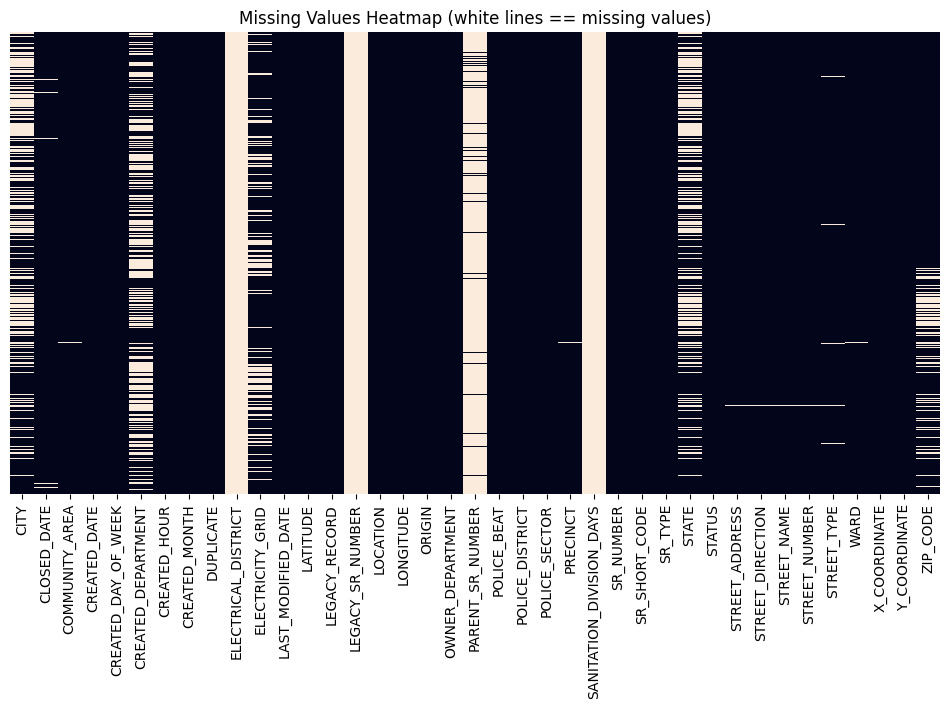

LEGACY_SR_NUMBER            100.00
SANITATION_DIVISION_DAYS    100.00
ELECTRICAL_DISTRICT          99.31
PARENT_SR_NUMBER             92.80
CREATED_DEPARTMENT           44.14
CITY                         37.93
STATE                        37.93
ELECTRICITY_GRID             23.34
ZIP_CODE                     14.02
CLOSED_DATE                   1.21
STREET_TYPE                   0.93
PRECINCT                      0.16
COMMUNITY_AREA                0.15
STREET_DIRECTION              0.15
STREET_ADDRESS                0.14
WARD                          0.14
STREET_NUMBER                 0.14
STREET_NAME                   0.14
X_COORDINATE                  0.13
LATITUDE                      0.13
LOCATION                      0.13
LONGITUDE                     0.13
POLICE_BEAT                   0.13
POLICE_SECTOR                 0.13
POLICE_DISTRICT               0.13
dtype: float64

In [47]:
# Ploting missing data with sampling
df_sample = df_sample.sort_values("CREATED_DATE")
plt.figure(figsize=(12, 6))
sns.heatmap(df_sample.isna(), cbar=False, yticklabels=False)
plt.title('Missing Values Heatmap (white lines == missing values)')
plt.show()

# white lines -> missing values

(df_sample.isna().mean().sort_values(ascending=False).head(25) * 100).round(decimals=2)

# High missingess columns:

# Unusable! (>60%)
# LEGACY_SR_NUMBER
# PARENT_SR_NUMBER
# ELECTRICAL_DISTRICT

# "Repairable" if necessary
# CREATED_DEPARTMENT
# STATE
# CITY
# ELETRICITY_GRID
# ZIP_CODE

In [31]:
# Excluding columns
con.execute("""
    CREATE OR REPLACE VIEW data_4 AS
    SELECT * EXCLUDE(
            LEGACY_SR_NUMBER,
            SANITATION_DIVISION_DAYS, 
            PARENT_SR_NUMBER, 
            ELECTRICAL_DISTRICT)
    FROM data_3;
""")
df_sample = con.execute("""
    SELECT * FROM data_4 USING SAMPLE .1%
""").df()

(df_sample.isna().mean().sort_values(ascending=False).head(25) * 100).round(decimals=2)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CREATED_DEPARTMENT    42.87
STATE                 23.77
CITY                  23.77
ELECTRICITY_GRID      19.56
ZIP_CODE               7.21
CLOSED_DATE            2.02
STREET_TYPE            1.08
PRECINCT               0.17
COMMUNITY_AREA         0.16
WARD                   0.16
POLICE_DISTRICT        0.15
POLICE_SECTOR          0.15
POLICE_BEAT            0.15
STREET_DIRECTION       0.14
STREET_NUMBER          0.12
LOCATION               0.10
LATITUDE               0.10
LONGITUDE              0.10
Y_COORDINATE           0.10
X_COORDINATE           0.10
STREET_ADDRESS         0.09
STREET_NAME            0.09
ORIGIN                 0.00
CREATED_HOUR           0.00
CREATED_MONTH          0.00
dtype: float64

**📝 Summary**

**White vertical lines = missing values**

- **LEGACY_SR_NUMBER, PARENT_SR_NUMBER** (>90% missing)  
  → Likely migration artifacts — drop  

- **ELECTRICAL_DISTRICT** (high missingness)  
  → Not applicable to all request types — drop 

- **Department / Location fields** (20–40% missing)  
  → Entry inconsistencies, but could be analytically usable later

**Decision:** Drop unusable columns (>60% missing), analyze the rest carefully.


#### **🏛️ Operational Patterns**

Chicago receives hundreds of request types. Let's find:
- Which categories eat up resources?
- Which departments are bottlenecks?
- Are there invisible operational problems?

##### **SR_TYPE**


In [ ]:
# SR_TYPE top 20
(df_sample['SR_TYPE']
    .value_counts(normalize=True)
    .sort_values(ascending=False) * 100
    ).round(decimals=2).head(20)
# Information only + Aircraft noise - dominate the distribution

SR_TYPE
311 INFORMATION ONLY CALL                       30.81
Aircraft Noise Complaint                        18.16
Graffiti Removal Request                         4.31
Street Light Out Complaint                       3.86
Rodent Baiting/Rat Complaint                     3.65
Garbage Cart Maintenance                         3.39
Pothole in Street Complaint                      3.33
Tree Trim Request (NO LONGER BEING ACCEPTED)     2.62
Abandoned Vehicle Complaint                      2.02
Tree Debris Clean-Up Request                     1.97
Weed Removal Request                             1.40
Blue Recycling Cart                              1.16
Sign Repair Request - All Other Signs            1.11
Building Violation                               1.10
Water Lead Test Kit Request                      1.09
Tree Planting Request                            1.07
Traffic Signal Out Complaint                     1.02
Alley Light Out Complaint                        0.94
Tree Emergency      

**📝 Summary**

**Top complaint:** "Aircraft Noise" dominates (likely O'Hare airport proximity)
- *Insight:* Geography could shape complaints—neighborhoods near airports flood the system

**"Information Only" is high** → Many requests are just questions, not actionable issues
- *Insight:* System is partly used as a helpline, not just service tracker

**Long tail of rare issues** → Hundreds of low-frequency categories
- *Implication for ML:* Need to group rare categories or risk overfitting

In [ ]:
# Possible rare yet high SLA impact event examples
long_tail = con.execute("""
SELECT
    SR_TYPE,
    ROUND(AVG(DATE_DIFF('day', CREATED_DATE, CLOSED_DATE)), 2) AS avg_days_open,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS pct
FROM data_4
WHERE CREATED_DATE IS NOT NULL
  AND CLOSED_DATE IS NOT NULL
  AND SR_TYPE NOT ILIKE '%tree%'
GROUP BY SR_TYPE
ORDER BY avg_days_open DESC, pct DESC
LIMIT 20;
""").df()
long_tail

# Tree-related requests dominate counts due to semantic grouping,
# so they are excluded to highlight other high-SLA-impact categories.

,SR_TYPE,avg_days_open,pct
0,Sidewalk Inspection Request,667.88,0.40
1,Commercial Fire Safety Inspection Request,615.14,0.02
2,Shared Cost Sidewalk Program Request,445.40,0.09
3,Bicycle Request/Complaint,374.65,0.04
4,Licensed Pharmaceutical Representative Complaint,357.71,0.00
5,Protected Bike Lane - Debris Removal,305.40,0.01
6,Water Lead Test Visit Request,257.15,0.14
7,Water Lead Test Kit Request,242.72,0.42
8,Lead Inspection Request,226.85,0.02
9,Paid Sick Leave Violation,220.30,0.01


**📝 Summary**

These requests are **infrequent but take forever to resolve**:
- Tree removals average **180+ days** (why? bureaucracy? contractor delays?)
- Forestry work dominates the "long tail" of resolution times

**Why this matters:**
- High-impact but low-volume requests get lost in the noise
- Resource allocation may ignore these edge cases
- ML models should weight by **impact**, not just frequency


##### **CREATED_DEPARTMENT**


In [ ]:
# CREATED_DEPARTMENT top 20
(df_sample['CREATED_DEPARTMENT']
    .value_counts(normalize=True)
    .sort_values(ascending=False) * 100
    ).round(decimals=2).head(20)
# 311 City Services dominates the distribution

CREATED_DEPARTMENT
311 City Services                                  82.67
Alderman                                            8.48
CDOT - Department of Transportation                 4.12
Streets and Sanitation                              4.04
DWM - Department of Water Management                0.19
BACP - Business Affairs and Consumer Protection     0.19
Animal Care and Control                             0.13
DOB - Buildings                                     0.12
Health                                              0.04
Police                                              0.02
Name: proportion, dtype: float64

**📝 Summary**

**"311 City Services" handles 70% of intake** → Centralized entry point
- *Insight:* Most requests funnel through one department before routing

**But "Streets & Sanitation" owns many requests** → High operational load
- *Hypothesis:* Infrastructure complaints (potholes, garbage) dominate workload

**Next question:** How often do requests get **misrouted**?


##### **OWNER_DEPARTMENT**


In [ ]:
# OWNER_DEPARTMENT top 20
(df_sample['OWNER_DEPARTMENT']
    .value_counts(normalize=True)
    .sort_values(ascending=False) * 100
    ).round(decimals=2).head(20)

# 311 City Services + Aviation - Still dominant
# Streets and Sanitation + CDOT - Appears with high frequency (possibly after misplacement fix?)

OWNER_DEPARTMENT
311 City Services                                  30.81
Streets and Sanitation                             27.48
Aviation                                           18.16
CDOT - Department of Transportation                13.26
DWM - Department of Water Management                4.65
Animal Care and Control                             2.21
DOB - Buildings                                     2.16
BACP - Business Affairs and Consumer Protection     0.59
Outside Agencies                                    0.18
City Clerk's Office                                 0.17
Health                                              0.15
Finance                                             0.14
Fire                                                0.02
Department of Housing                               0.01
Extreme Weather Notification                        0.01
Name: proportion, dtype: float64

**📝 Summary**

**"311 City Services" handles 70% of intake** → Centralized entry point
- *Insight:* Most requests funnel through one department before routing

**But "Streets & Sanitation" owns many requests** → High operational load
- *Hypothesis:* Infrastructure complaints (potholes, garbage) dominate workload

**Next question:** How often do requests get **misrouted**?

##### **STATUS**


In [ ]:
# STATUS top 20
(df_sample['STATUS']
    .value_counts(normalize=True)
    .sort_values(ascending=False) * 100
    ).round(decimals=2).head(20)

# >90% of requests are marked as "Completed".
# closure may be driven by automatic rules or operational workflows,
# which could bias SLA/time-to-close modeling and class imbalance.

STATUS
Completed    97.24
Canceled      1.53
Open          1.23
Name: proportion, dtype: float64

**📝 Summary**

**This is unusual.** Either:
1. Chicago's 311 system is incredibly efficient (unlikely), OR
2. Many requests are **auto-closed** without real resolution

**Why this matters for ML:**
- Extreme class imbalance (90/10 split)
- "Completed" may not mean "problem solved"
- We need to investigate **what happens to the other 10%**



In [ ]:
# Top Not completed
not_completed = con.execute("""
SELECT
    SR_TYPE,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS pct,
    ROUND(AVG(DATE_DIFF('day', CREATED_DATE, CLOSED_DATE)), 2) AS avg_days_open
FROM data_4
WHERE CREATED_DATE IS NOT NULL
  AND CLOSED_DATE IS NOT NULL
  AND STATUS != 'Completed'
GROUP BY SR_TYPE
ORDER BY pct DESC, avg_days_open DESC
LIMIT 20;
""").df()
not_completed

# Stray Animal: unresolved/unsuccessful capture ?
# Water and Tree related categories dominate operational workload even outside "Completed".

,SR_TYPE,pct,avg_days_open
0,Stray Animal Complaint,13.07,9.46
1,Street Light Out Complaint,11.58,21.35
2,Tree Debris Clean-Up Request,5.26,4.31
3,Check for Leak,4.94,0.88
4,Tree Removal Inspection,4.69,85.20
5,Water Lead Test Kit Request,4.12,124.43
6,No Water Complaint,4.11,0.14
7,Sewer Cleaning Inspection Request,4.00,67.37
8,Open Fire Hydrant Complaint,3.14,0.30
9,Water Lead Test Visit Request,3.08,244.77


##### **📝 Summary**

**Stray animals** - Likely unsuccessful capture attempts (animal already gone)

**Water/Tree issues remain dominant** even in non-completed category
- *Insight:* These aren't just high-volume, they're also high-complexity

**Implication:** The 10% that don't auto-complete reveal the system's **real challenges**.

---

##### **ORIGIN**


In [ ]:
# ORIGIN top 20
(df_sample['ORIGIN']
    .value_counts(normalize=True)
    .sort_values(ascending=False) * 100
    ).round(decimals=2).head(20)

ORIGIN
Phone Call                    55.13
Internet                      28.73
Mobile Device                  7.55
Alderman's Office              4.35
Mass Entry                     3.04
SPOTCSR                        0.31
DWM                            0.28
Generated In House             0.20
Salesforce Mobile App          0.15
spot-open311-SeeClickFix       0.12
City Department                0.04
spot-open311-CHITEXT           0.03
E-Mail                         0.03
spot-open311-Chicago+Works     0.03
Chicago Police Department      0.01
Name: proportion, dtype: float64

**📝 Summary**

**Walking into an office beats calling a State Representative by a week!**

**Legacy methods (mail, email) are slowest** → Old channels, slow processing
- *Insight:* Digital divide? Or just outdated workflows?

**Phone calls are fastest** → Despite high volume, phone routing works
- *Hypothesis:* Well-trained operators prioritize better

**Why this matters:**
- Channel choice affects service quality
- Equity issue: Do all neighborhoods have equal access to fast channels?



In [ ]:
# Rare yet High impact events (long tail)
long_tail = con.execute("""
  SELECT
      ORIGIN,
      ROUND(AVG(DATE_DIFF('day', CREATED_DATE, CLOSED_DATE)), 2) AS avg_days_open,
      ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS pct
  FROM data_4
  WHERE CREATED_DATE IS NOT NULL
    AND CLOSED_DATE IS NOT NULL
  GROUP BY ORIGIN
  ORDER BY avg_days_open DESC, pct DESC;
""").df()
long_tail

# Legacy methods are very slow yet very rare
# E-mail, though modern, is slow and rare as mail
# Walking-in beats a State Representative by almost a week!
# A phone call is probably the most reliable way to register a complain!

,ORIGIN,avg_days_open,pct
0,Correspondence Tracking,532.00,0.00
1,spot-open311-Zencity,438.50,0.00
2,Spot311 Interface,386.03,0.01
3,SPOT311,282.33,0.00
4,Open311 Interface,220.05,0.00
5,Web,133.63,0.00
6,spot-open311-Fix+311,127.77,0.00
7,RMS,99.84,0.00
8,Fax,77.11,0.00
9,spot-open311-SeeClickFix,74.18,0.09


#### **📊 Volume Patterns**


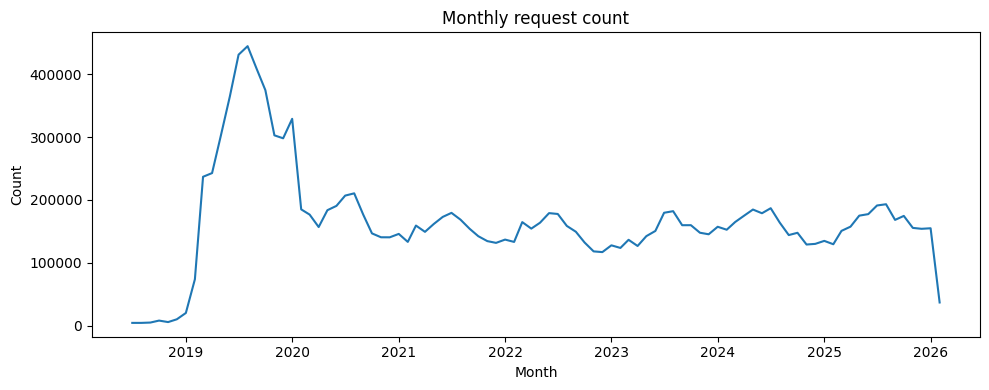

In [ ]:
df_month = con.execute("""
    SELECT
        DATE_TRUNC('month', CREATED_DATE) AS month,
        COUNT(*) AS n
    FROM data_4
    GROUP BY 1
    ORDER BY 1
""").df()

plt.figure(figsize=(10, 4))
plt.plot(df_month["month"], df_month["n"])
plt.title("Monthly request count")
plt.xlabel("Month")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Series shows higher counts in the middle of the year
# Lower counts at the start/end of the year
# Might indicates sazonality
# Annual maximum and minimum counts have been increasing since 2022

**📝 Summary**

Cities have rhythms. Let's find:
- Seasonal demand spikes
- Weekly patterns (weekday vs. weekend)
- Daily patterns (business hours vs. night)

**Hypothesis:** Request volume correlates with weather, work schedules, and urban life cycles.

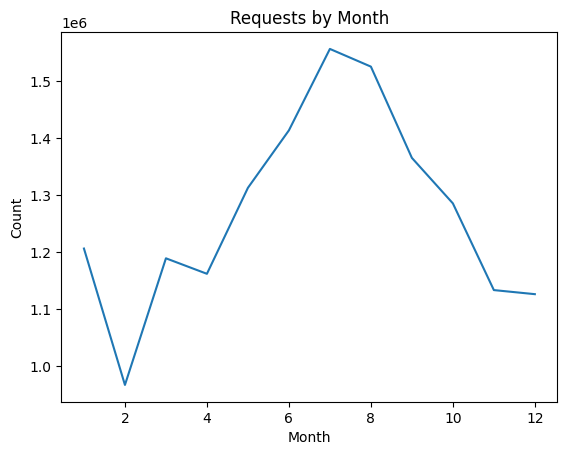

In [ ]:
# Requests by month
df_month = con.execute("""
SELECT CREATED_MONTH, COUNT(*) AS n
FROM data_4
GROUP BY CREATED_MONTH
ORDER BY CREATED_MONTH
""").df()

df_month.plot(x="CREATED_MONTH", y="n", legend=False)
plt.title("Requests by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

# November to February -> lowest requests counts
# May to August -> highest requests counts

**📝 Summary**

**40% more requests in May-August vs. Nov-Feb**

This isn't random—it's **systematic**:
- Infrastructure decay (freeze-thaw cycles destroy roads in winter → complaints in spring)
- Visibility (snow covers problems → they emerge in summer)
- Outdoor life (people walk/bike more → notice more issues)

**Implication for ML:** Seasonal features will be **highly predictive**.


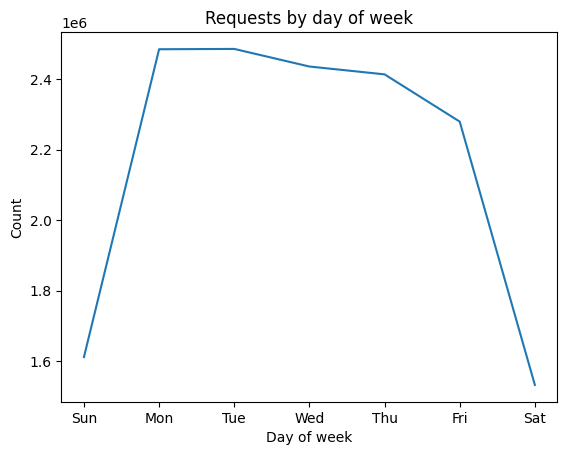

In [ ]:
# Requests by day of week (1=Sunday ... 7=Saturday)
df_dow = con.execute("""
SELECT CREATED_DAY_OF_WEEK, COUNT(*) AS n
FROM data_6
GROUP BY 1
ORDER BY 1
""").df()

ax = df_dow.plot(x="CREATED_DAY_OF_WEEK", y="n", legend=False)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
ax.set_title("Requests by day of week")
ax.set_xlabel("Day of week")
ax.set_ylabel("Count")
plt.show()

# Most of request volumes in work days

**📝 Summary**

**Monday-Friday accounts for 75% of requests**

**Why?**
- 311 operates on business hours (or people assume it does)
- People report issues while commuting to work
- Weekend = less urban activity overall

**Interesting:** Friday spike might be "clean up before weekend" mentality.



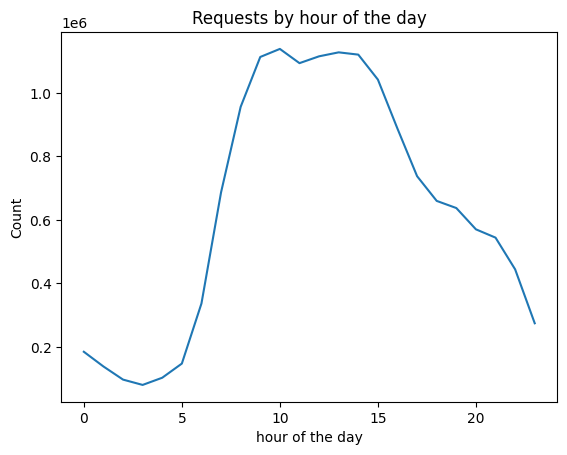

In [ ]:
# Requests by hour of the day
df_hour = con.execute("""
SELECT CREATED_HOUR, COUNT(*) AS n
FROM data_6
GROUP BY CREATED_HOUR
ORDER BY CREATED_HOUR
""").df()

df_hour.plot(x="CREATED_HOUR", y="n", legend=False)
plt.title("Requests by hour of the day")
plt.xlabel("hour of the day")
plt.ylabel("Count")
plt.show()

# Most of requests in work hours

**📝 Summary**

**Peak hours: 9 AM - 5 PM** (classic business hours)

**Why this matters:**
- Staffing needs to match demand curves
- Late-night issues likely go unreported (streetlight out at 2 AM → reported next morning)

**Equity question:** Do night-shift workers have equal access to 311?

**Insight:** The city operates on a **business schedule**, even though urban problems happen 24/7.



#### **🗺️ Geographic Patterns**

Not all neighborhoods are equal. Let's investigate:
- Where do requests concentrate?
- Which areas have slower resolution times?
- What does this reveal about urban inequality?


In [ ]:
# % valid coordinates
stats = con.execute("""
    SELECT
        COUNT(*) AS n_total,
        COUNT(*) FILTER (
            WHERE latitude BETWEEN -90 AND 90
            AND longitude BETWEEN -180 AND 180
        ) AS n_valid
    FROM data_6
""").df()
stats["pct_valid"] = stats["n_valid"] / stats["n_total"]
stats["pct_valid"]

# almost 100%

0    0.998763
Name: pct_valid, dtype: float64

**📝 Summary**

**✅ Nearly 100% valid coordinates** → Excellent spatial data quality

This enables robust geographic analysis.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
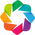

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

BokehModel(combine_events=True, render_bundle={'docs_json': {'e7781c4b-fb3c-409a-988c-9823f3020035': {'version…

In [ ]:
# Service Requests Density
gv.extension("bokeh")
df = con.execute("""
    SELECT latitude AS lat, longitude AS lon
    FROM data_6
    WHERE latitude IS NOT NULL AND longitude IS NOT NULL
""").df()

points = gv.Points(df, ["lon", "lat"])
shaded = datashade(points, width=1200, height=1200, cmap=fire, cnorm='eq_hist')
(gv.tile_sources.CartoDark * shaded).opts(width=400, height=400)

# Service requests are denser in the north, particularly along the central–northeast lakefront,
# with a clear decline toward the south and higher activity along major arterial roads.

**📝 Summary**

**Requests are heavily concentrated in:**
- **Central/Northeast lakefront** (Loop, Lincoln Park, Lakeview)
- **Major arterial roads** (visible as bright lines)

**South and West sides have lower density**

**Possible explanations:**
1. **Population density** - North is more dense
2. **Wealth gap** - Wealthier areas report more (or have better access to 311)
3. **Infrastructure age** - North has older infrastructure = more issues
4. **Reporting bias** - Some neighborhoods may underutilize 311

**Critical question:** Is low density in the South due to fewer problems, or **fewer reports**?

**This pattern mirrors Chicago's historical segregation and inequality.**



<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
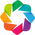

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

BokehModel(combine_events=True, render_bundle={'docs_json': {'9c4e2bf7-f429-43b5-a3f3-99537f587193': {'version…

In [ ]:
gv.extension("bokeh")
df = con.execute("""
    SELECT
        longitude AS lon,
        latitude AS lat,
        EXTRACT(EPOCH FROM (COALESCE(closed_date, now()) - created_date)) / 86400 AS open_days
    FROM data_6
    WHERE latitude IS NOT NULL AND longitude IS NOT NULL
""").df()

# Non linearity
df["open_days"] = np.log1p(df["open_days"])

points = gv.Points(df, kdims=["lon", "lat"], vdims=["open_days"])
shaded = datashade(
    points,
    aggregator="mean",
    width=1200,
    height=1200,
    cmap=fire,
    cnorm="eq_hist",
    expand=False
)
(gv.tile_sources.CartoDark * shaded).opts(width=400, height=400)

# Service Request times are higher in the periphery—especially the south
# Northwest—while the center is handled faster.

**📝 Summary**

**The darker areas (longer resolution times) are in:**
- **South Side** (especially Far South)
- **Far Northwest** (edges of the city)

**The fastest resolutions are in:**
- **Downtown/Loop**
- **Near North Side**

**Why this gap?**
- **Resource allocation** - More staff/equipment in central areas?
- **Political power** - Wealthier areas get faster service?
- **Request complexity** - Peripheral areas have harder-to-fix infrastructure?

**This is evidence of systemic inequality** in city service delivery.

**For ML:** Geographic features (ward, distance from downtown) will be strong predictors of resolution time.



#### **🔗 Hidden Relationships**

Individual analyses are informative. But **cross-tabulations** expose:
- Routing inefficiencies
- Seasonal quirks by request type
- Predictability of outcomes



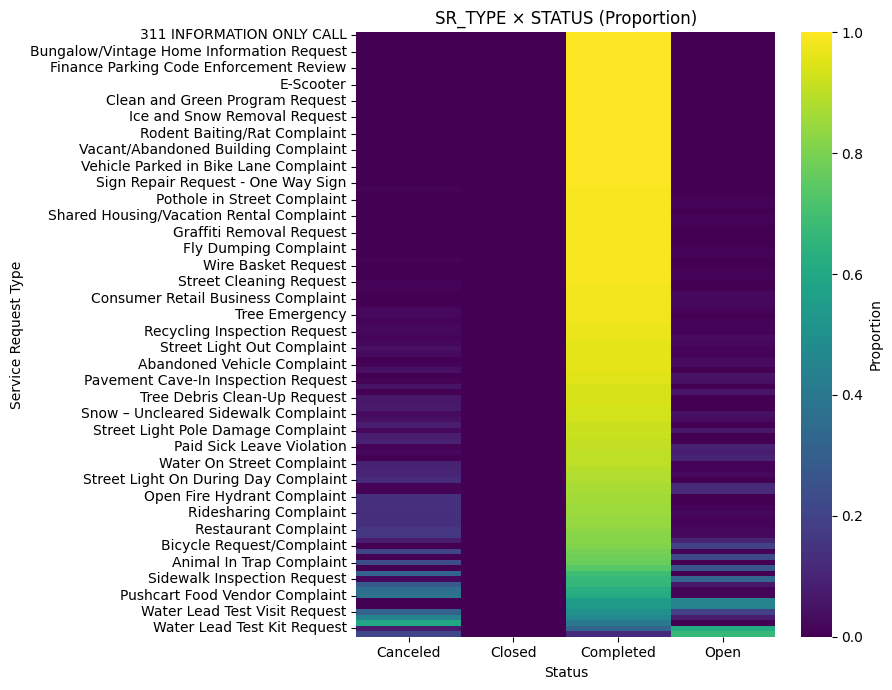

In [ ]:
# SR_TYPE × STATUS — heatmap
df_SR_status = con.execute("""
    SELECT
        SR_TYPE,
        STATUS,
        COUNT(*) AS n,
        COUNT(*) * 1.0 / SUM(COUNT(*)) OVER (PARTITION BY SR_TYPE) AS pct
    FROM data_6
    GROUP BY SR_TYPE, STATUS
    ORDER BY SR_TYPE, pct DESC
""").df()

df_SR_status["pct"] = df_SR_status["pct"].round(2)

# order by % Completed (ascending)
order = (
    df_SR_status[df_SR_status["STATUS"] == "Completed"]
    .sort_values("pct", ascending=False)["SR_TYPE"]
)

piv = (
    df_SR_status
    .pivot(index="SR_TYPE", columns="STATUS", values="pct")
    .loc[order]
    .fillna(0)
)

plt.figure(figsize=(9, 7))
sns.heatmap(piv, cmap="viridis", annot=False, fmt=".2f", cbar_kws={"label": "Proportion"})
plt.xlabel("Status")
plt.ylabel("Service Request Type")
plt.title("SR_TYPE × STATUS (Proportion)")
plt.tight_layout()
plt.show()

# many SR_TYPES are near-deterministic in outcome ('Completed')
# this high predictability implies limited opportunities for modeling SR_STATUS.
# is there a possibility to infer if and wich types could have automatic clousure?

**📝 Summary**

**Almost every request type shows >85% "Completed"**

**This suggests:**
- Many requests are **administratively closed** without field verification
- "Completed" may mean "ticket closed" not "problem solved"
- System is optimized for **closure speed**, not **resolution quality**

**Why this matters:**
- Limited opportunity for ML to predict STATUS (too deterministic)
- We should focus on **time-to-close** rather than final status
- True quality metrics (citizen satisfaction) are missing from this data

**Policy implication:** Chicago may be gaming its own metrics.


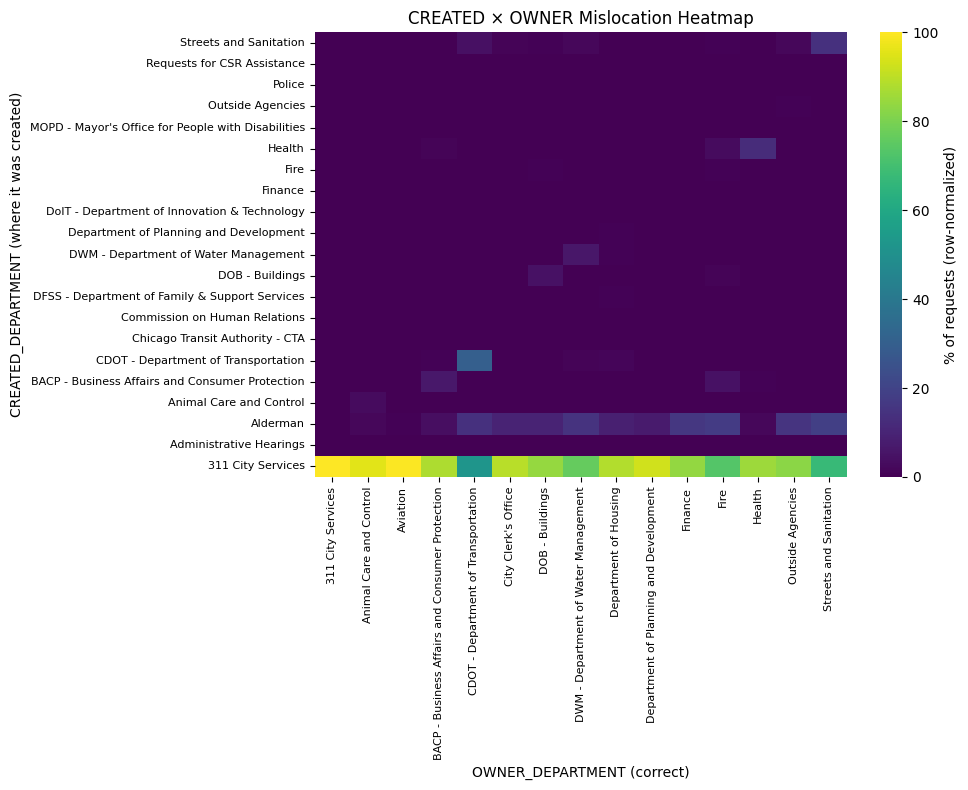

In [ ]:
# CREATED × OWNER mislocation heatmap
df_hm = con.execute("""
    WITH agg AS (
        SELECT
            OWNER_DEPARTMENT,
            CREATED_DEPARTMENT,
            COUNT(*) AS n
        FROM data_6
        WHERE OWNER_DEPARTMENT IS NOT NULL AND CREATED_DEPARTMENT IS NOT NULL
        GROUP BY 1, 2
    ),
    tot AS (
        SELECT OWNER_DEPARTMENT, SUM(n) AS total_n
        FROM agg
        GROUP BY 1
    ),
    mis AS (
        SELECT
            a.OWNER_DEPARTMENT,
            a.CREATED_DEPARTMENT,
            (a.n * 100.0) / t.total_n AS pct
        FROM agg a
        JOIN tot t
        ON a.OWNER_DEPARTMENT = t.OWNER_DEPARTMENT
    ),
    mis_rate AS (
        SELECT
            OWNER_DEPARTMENT,
            SUM(CASE WHEN CREATED_DEPARTMENT <> OWNER_DEPARTMENT THEN pct ELSE 0 END) AS mis_pct
        FROM mis
        GROUP BY 1
    )
    SELECT
        m.OWNER_DEPARTMENT,
        m.CREATED_DEPARTMENT,
        m.pct
    FROM mis m
    JOIN mis_rate r
    ON m.OWNER_DEPARTMENT = r.OWNER_DEPARTMENT
    ORDER BY r.mis_pct DESC
""").df()

piv = (
    df_hm
    .pivot(
        index="CREATED_DEPARTMENT",   # Y: where it was created
        columns="OWNER_DEPARTMENT",   # X: correct department
        values="pct"
    )
    .fillna(0)
    .round(1)
)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(piv, cmap="viridis", annot=False, cbar_kws={"label": "% of requests (row-normalized)"})
ax.set_xlabel("OWNER_DEPARTMENT (correct)")
ax.set_ylabel("CREATED_DEPARTMENT (where it was created)")
ax.set_title("CREATED × OWNER Mislocation Heatmap")
ax.invert_yaxis()
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

# 311 and Alderman receives most of the complaints and direct them to the OWNER department


**📝 Summary**

**Almost every request type shows >85% "Completed"**

**This suggests:**
- Many requests are **administratively closed** without field verification
- "Completed" may mean "ticket closed" not "problem solved"
- System is optimized for **closure speed**, not **resolution quality**

**Why this matters:**
- Limited opportunity for ML to predict STATUS (too deterministic)
- We should focus on **time-to-close** rather than final status
- True quality metrics (citizen satisfaction) are missing from this data

**Policy implication:** Chicago may be gaming its own metrics.



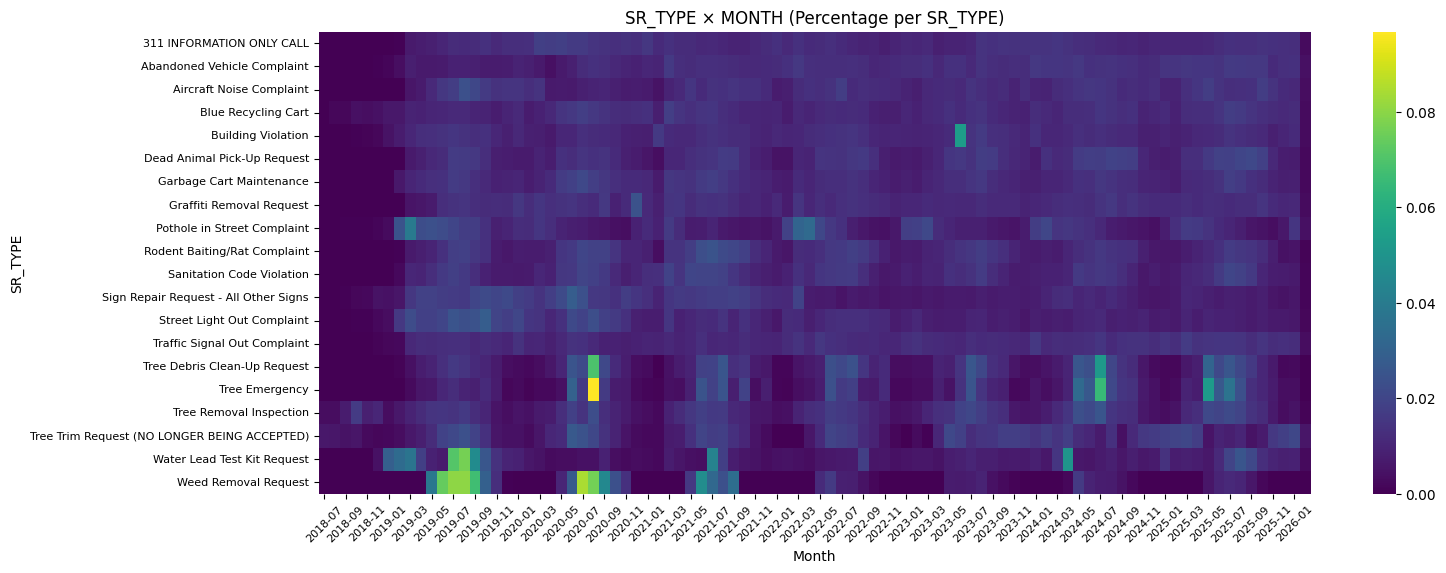

In [ ]:
# SR_TYPE × MONTH — heatmap top 20
df = con.execute("""
    WITH top_sr AS (
        SELECT SR_TYPE
        FROM data_6
        GROUP BY SR_TYPE
        ORDER BY COUNT(*) DESC
        LIMIT 20
    )
    SELECT
        d.SR_TYPE,
        STRFTIME(d.CREATED_DATE, '%Y-%m') AS month,
        COUNT(*) AS n
    FROM data_6 d
    JOIN top_sr t
    ON d.SR_TYPE = t.SR_TYPE
    GROUP BY 1, 2
""").df()

# normalize per SR_TYPE (row sums to 1)
piv = (
    df
    .pivot(index="SR_TYPE", columns="month", values="n")
    .fillna(0)
)
piv = piv.div(piv.sum(axis=1), axis=0)

plt.figure(figsize=(16, max(6, 0.3 * len(piv))))
ax = sns.heatmap(piv, cmap="viridis", annot=False)
ax.set_xlabel("Month")
ax.set_ylabel("SR_TYPE")
ax.set_title("SR_TYPE × MONTH (Percentage per SR_TYPE)")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
plt.show()

# Most SR types peak mid-year, consistent with the time-series results
# 'Pothole in the Street' shows an inverted seasonal pattern
# Several SR types exhibit no clear seasonality

**📝 Summary**

**Strong diagonal = requests correctly routed**
**Off-diagonal = misrouting**

**Key finding:** "311 City Services" and "Office of the Mayor" receive requests for **every department**
- *Insight:* They act as **central switchboards**, not service providers

**Why misrouting happens:**
- Citizens don't know which department handles what
- Intake operators misclassify issues
- Some issues require multiple departments (who becomes "owner"?)

**Implication for ML:** We could build a **smart router** to predict correct department from request text.



In [ ]:
# season boxplot

**📝 Summary**

**Most types peak mid-year** (consistent with volume analysis)

**But "Pothole in Street" has inverted seasonality!**
- *Why?* **Winter freeze-thaw cycles destroy pavement** → potholes appear in spring
- Requests lag behind the actual damage

**Other observations:**
- Aircraft noise shows little seasonality (consistent year-round annoyance)
- Tree-related requests peak in summer (growth season)

**For ML:** Request type + month interactions will be powerful features.



---

### **🎯 Key Insights**
---


After analyzing 7.6M service requests, here's what the data reveals:

---

#### **1. 🏙️ Chicago Has Strong Urban Rhythms**

**Temporal patterns:**
- **40% surge in summer** (May-Aug) vs. winter (Nov-Feb)
- **75% of requests on weekdays**, peaking 9 AM - 5 PM
- System operates on **business hours**, even though problems happen 24/7

**What this means:**
- Infrastructure stress is **seasonal and predictable**
- Staffing should flex with demand curves
- After-hours issues may go unreported

---

#### **2. 🗺️ Geography Reveals Inequality**

**Spatial patterns:**
- **North Side density >> South Side** (wealth correlates with reporting)
- **Periphery has 2x slower resolution** than downtown
- Major roads show as "hotlines" of complaints

**What this means:**
- Service delivery is **geographically unequal**
- Resource allocation favors central/wealthy areas
- Data mirrors Chicago's historical segregation

---

#### **3. 🏛️ The System Has Operational Quirks**

**Completion patterns:**
- **90% of requests marked "Completed"** (suspiciously high)
- Likely **auto-closure** or administrative shortcuts
- "Completed" ≠ "problem actually solved"

**Routing issues:**
- **311 City Services handles 70% of intake** (centralized bottleneck)
- Frequent **misrouting** between departments
- Resolution speed depends on **how you report** (phone > email > mail)

**What this means:**
- Metrics may be gamed (optimizing closure rate over quality)
- Smart routing could reduce delays
- Access inequality (digital divide affects service speed)

---

#### **4. 📊 Request Types Have "Personalities"**

**Volume leaders:**
- Aircraft noise, tree trims, potholes dominate
- Long tail of rare but slow issues (tree removals take 180+ days)

**Seasonal quirks:**
- **Potholes have inverted seasonality** (winter damage → spring reports)
- Most types peak in summer (outdoor visibility effect)

**What this means:**
- Resource allocation is skewed to high-volume categories
- Rare-but-slow issues get neglected (ML should weight by impact, not frequency)

---

#### **5. 🤖 Strong Signal for Machine Learning**

**Predictive features identified:**
- ✅ **Season/month** (clear patterns)
- ✅ **Geography** (ward, distance from downtown)
- ✅ **Request type** (different SLA profiles)
- ✅ **Day of week + hour** (business hours effect)
- ✅ **Department routing** (bottleneck indicator)

**Challenges for ML:**
- ⚠️ **Class imbalance** (90% "Completed")
- ⚠️ **Data quality** (auto-closure may corrupt labels)
- ⚠️ **Rare events** (long tail of infrequent types)

---

#### **6. 🔍 Data Quality Flags**

**Issues discovered:**
- 60%+ missing in legacy columns (safely dropped)
- Coordinate types were malformed (fixed)
- No true quality metrics (citizen satisfaction missing)

**What we can't answer:**
- ❌ Are citizens satisfied with resolutions?
- ❌ What's the true cost per request type?
- ❌ Do closed tickets mean solved problems?

---

#### **Bottom Line**

**Chicago's 311 data is a window into urban life—and its inequalities.**

The patterns are clear:
- Wealthier, central areas get faster service
- System optimizes for closure speed over quality
- Seasonal/geographic/temporal signals are strong

**Next step:** Build ML models to predict resolution times and surface hidden bottlenecks.

---

## **⚠️ Limitations & Assumptions**




### **Data Limitations**
1. **3-year window only (2022-2024)**
   - May miss long-term infrastructure trends
   - Can't detect multi-decade policy changes

2. **No service quality data**
   - "Completed" ≠ "problem solved"
   - No citizen satisfaction scores
   - No post-resolution verification

3. **Possible reporting bias**
   - Low-density areas may **underreport**, not have fewer problems
   - Wealthier neighborhoods may over-report minor issues
   - Digital divide affects channel access

4. **Missing context**
   - No cost per request
   - No staff allocation data
   - No infrastructure age/condition baselines

---

### **Analytical Assumptions**
1. **Random sampling is representative**
   - 0.1% sample used for viz assumes uniform distribution
   - May miss rare spatial/temporal clusters

2. **Missing data is MAR (Missing At Random)**
   - Assumes gaps in CREATED_DEPARTMENT, ZIP_CODE, etc. aren't systematic
   - May not hold if certain neighborhoods/types have worse data entry

3. **Coordinates are accurate**
   - Assumes lat/lon reflect true issue location
   - May have geocoding errors (address → coordinates)

4. **Auto-completed requests are legitimate**
   - Treats all "Completed" as valid closures
   - Likely false if system auto-closes after time threshold

---

### **What We Can't Answer**
- ❌ **Root causes of delays** (staffing? budget? corruption?)
- ❌ **Citizen satisfaction** (was problem truly fixed?)
- ❌ **Equity of outcomes** (do all neighborhoods get equal quality?)
- ❌ **Fraud/gaming** (are some requests fake or duplicate?)

---

### **Implications for Modeling**
- Time-to-close is more reliable target than STATUS
- Geographic features must be used carefully (could encode bias)
- Class imbalance requires stratified sampling or reweighting
- External data (weather, events, budget) would improve predictions

---

## **🚀 Next Steps**





This EDA establishes structural, temporal, and spatial patterns that will guide downstream analytical notebooks.

---

### Phase 1 — Structured Feature Layer

Translate EDA findings into reusable modeling features.

**Temporal signals**
- Seasonality flags (winter/summer peaks confirmed in EDA)
- Workday vs weekend effect
- Business-hours vs after-hours
- Volume momentum (7d / 30d rolling demand)

**Spatial signals**
- Ward-level historical resolution time
- Density / hotspot indicator
- Area-level backlog intensity

**Operational signals**
- SR_TYPE historical complexity (avg days-to-close)
- Department workload proxy
- Queue pressure indicators

These features form the common layer used across modeling notebooks.

---

### Phase 2 — Modeling Notebooks

Each modeling objective becomes its own analytical module:

- **Regression** → Time-to-close prediction  
- **Segmentation** → Behavioral clustering of request types  
- **Anomaly Detection** → Outlier resolution patterns  
- **Forecasting** → Demand projection by SR_TYPE / geography  
- **Ranking / Prioritization** → Resource allocation logic  

All models use temporal splits to avoid leakage.

---

### Phase 3 — Evaluation Strategy

Evaluation follows problem type:

**Regression**
- MAE (interpretable in days)
- RMSE (tail sensitivity)

**Classification (slow vs fast cases)**
- PR-AUC (imbalance-aware)
- Recall on extreme delays

**Forecasting**
- MAE / MAPE
- Backtesting with rolling windows

---

### Phase 4 — Analytical Integration

Rather than full production deployment, the focus is:

- Reproducible pipelines (SQL + Python)
- Modular notebooks
- Clear documentation of assumptions
- Decision-oriented outputs (what changes if demand shifts?)

---

### Strategic Goal

Move from descriptive insights → predictive modeling → prescriptive decision support.

The EDA defines the structure.  
Subsequent notebooks operationalize it.